# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Deep Learning. </center>

In [6]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import os
import string
import pandas as pd

# RANDOM_STATE

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
RANDOM_STATE = 1337
seed_everything(RANDOM_STATE)

# Данные

In [12]:
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

In [13]:
preprocess=transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(1),
    transforms.Normalize([0.485], [0.229])
    ])

In [14]:
BATCH_SIZE = 100
TTD = ['train', 'test']

In [15]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

use_cuda

True

In [16]:
train_loader = DataLoader(datasets.ImageFolder(root = 'train', transform=preprocess), batch_size=BATCH_SIZE, shuffle=True, **kwargs) 
test_loader = DataLoader(datasets.ImageFolder(root = 'test', transform=preprocess), batch_size=BATCH_SIZE, shuffle=True, **kwargs) 

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

In [17]:
import time
import copy

In [18]:
device = torch.device("cuda:0" if use_cuda else "cpu")

In [19]:
def train(model, train_loader, criterion, optimizer, scheduler, device, epoch, verbose = True):
  model.train()
  train_loss = 0.0
  correct_train = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()

      data, target = data.to(device), target.to(device)
      
      output = model(data)
      loss = criterion(output, target)
      
      loss.backward()
      optimizer.step()
      
      if verbose:
        display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            epoch, (batch_idx+1) * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)

      _, predicted = torch.max(output.data, 1)
      train_loss += loss.item()* data.size(0)
      correct_train += torch.sum(predicted == target.data)
  
  
  epoch_loss = train_loss / len(train_loader.dataset)
  epoch_acc = 100.*(correct_train.double() / len(train_loader.dataset))
  if verbose:
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
        epoch_loss,correct_train, len(train_loader.dataset), epoch_acc))
  
  if scheduler:
    scheduler.step()
    
  return epoch_loss,epoch_acc

In [20]:
def test(model, criterion, device, test_loader, verbose):
  model.eval()
  test_loss = 0
  correct_test = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output, target) 
         
          _, predicted = torch.max(output.data, 1) 
          test_loss += loss.item()* data.size(0)
          correct_test += torch.sum(predicted == target.data)

  test_loss = test_loss / len(test_loader.dataset)
  accuracy = 100. * correct_test.double() / len(test_loader.dataset)

  if verbose:
    print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct_test, len(test_loader.dataset),
        accuracy))
  return test_loss,accuracy.item()

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

In [21]:
class NetLr(nn.Module):

    act_dict = nn.ModuleDict([
                ['smax', nn.Softmax()],
                ['relu', nn.ReLU()],
                ['sigm', nn.Sigmoid()],
                ['lsmax', nn.LogSoftmax()]
        ])
    

    def __init__(self, ll, act=None, drop=None, norm='bn'):

        super(NetLr, self).__init__()        
       
        #FC
        self.linears = nn.ModuleList(
            [nn.Linear(ll[i], ll[i+1]) for i in range(len(ll) - 1)]
        )
        
        #NORMALIZATION
        if not norm:
          self.normalizations = [None]*(len(ll) - 2)
        else:
          self.normalizations = nn.ModuleList(
              [nn.BatchNorm1d(i) for i in ll[1: -1]]
        )

        #DROP
        if not drop:
          drop = [0]*(len(ll) - 2)
        self.drops = nn.ModuleList(
            [nn.Dropout(p) for p in drop]
        )

        #ACTIVATIONS
        if not act:
          act = ['relu']*(len(ll) - 2) + ['lsmax']
        self.activations = nn.ModuleList(
            [NetLr.act_dict[i] for i in act]
        )
            
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        for l, a, d, n in zip(self.linears, self.activations, self.drops, self.normalizations):
            x = l(x)
            if n:
              x = n(x)
            x = d(x)
            x = a(x)
        x = self.linears[-1](x)
        x = self.activations[-1](x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [22]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [23]:
criterion = nn.NLLLoss()

**2 скрытых слоя**


Модель плохо обучается, если первый скрытый слой больше 500 и меньше 150 и если второй слой больше 300 или почти такой же как выходной.

Batch Norm увеличил качество, но не сильно. Регуляризация не помогла.

Дроп аут, даже очень маленький, очень сильно снижает качество.


Оптимальная модель:


In [ ]:
ll = [28*28, 260, 90, 26]
net = NetLr(ll).to(device)

In [ ]:
criterion = nn.NLLLoss()

optimizer= optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
for i in range(6):
  train(net, train_loader, criterion, optimizer, scheduler, device, i)
  test(net, criterion, device, test_loader)

'Train Epoch: 0 [65000/65000 (100%)] Loss: 0.444137'

Train set: Average loss: 0.8092, Accuracy: 50801/65000 78%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.4577, Accuracy: 11142/13000 (86%)



'Train Epoch: 1 [65000/65000 (100%)] Loss: 0.389235'

Train set: Average loss: 0.3806, Accuracy: 57126/65000 88%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.3719, Accuracy: 11480/13000 (88%)



'Train Epoch: 2 [65000/65000 (100%)] Loss: 0.521126'

Train set: Average loss: 0.3022, Accuracy: 58554/65000 90%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.3453, Accuracy: 11491/13000 (88%)



'Train Epoch: 3 [65000/65000 (100%)] Loss: 0.184074'

Train set: Average loss: 0.2095, Accuracy: 60619/65000 93%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.2888, Accuracy: 11785/13000 (91%)



'Train Epoch: 4 [65000/65000 (100%)] Loss: 0.167482'

Train set: Average loss: 0.1855, Accuracy: 61070/65000 94%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.2831, Accuracy: 11802/13000 (91%)



'Train Epoch: 5 [65000/65000 (100%)] Loss: 0.141828'

Train set: Average loss: 0.1743, Accuracy: 61350/65000 94%

Adjusting learning rate of group 0 to 1.0000e-05.
Val set: Average loss: 0.2786, Accuracy: 11837/13000 (91%)



In [ ]:
PATH = f'/content/drive/MyDrive/Lab_2/cifar_net{random.randint(1, 10000)}.pth'
torch.save(net.state_dict(), PATH)

**3 скрытыйх слоя**

Всё, что было сказанно про предыдущую верно и для этой.



Вот оптимальная модель:

In [ ]:
Сll = [784, 392, 128, 64, 26]
#act = ['sigm']*3
net = NetLr(ll, drop=[0]*3).to(device)

In [ ]:
optimizer= optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 6], gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
for i in range(7):
  train(net, train_loader, criterion, optimizer, scheduler, device, i)
  test(net, criterion, device, test_loader)

'Train Epoch: 0 [65000/65000 (100%)] Loss: 0.541517'

Train set: Average loss: 0.6689, Accuracy: 51370/65000 79%

Adjusting learning rate of group 0 to 1.0000e-02.
Val set: Average loss: 0.4270, Accuracy: 11201/13000 (86%)



'Train Epoch: 1 [65000/65000 (100%)] Loss: 0.425068'

Train set: Average loss: 0.3767, Accuracy: 56932/65000 88%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.3606, Accuracy: 11465/13000 (88%)



'Train Epoch: 2 [65000/65000 (100%)] Loss: 0.174945'

Train set: Average loss: 0.2245, Accuracy: 60055/65000 92%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.2611, Accuracy: 11894/13000 (91%)



'Train Epoch: 3 [65000/65000 (100%)] Loss: 0.226625'

Train set: Average loss: 0.1893, Accuracy: 60710/65000 93%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.2566, Accuracy: 11920/13000 (92%)



'Train Epoch: 4 [65000/65000 (100%)] Loss: 0.237067'

Train set: Average loss: 0.1716, Accuracy: 61094/65000 94%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.2523, Accuracy: 11938/13000 (92%)



'Train Epoch: 5 [65000/65000 (100%)] Loss: 0.102231'

Train set: Average loss: 0.1559, Accuracy: 61376/65000 94%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.2592, Accuracy: 11917/13000 (92%)



'Train Epoch: 6 [65000/65000 (100%)] Loss: 0.235221'

Train set: Average loss: 0.1325, Accuracy: 61952/65000 95%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.2515, Accuracy: 11958/13000 (92%)



**confusion matrix**

In [68]:
LABELS = list(string.ascii_lowercase)

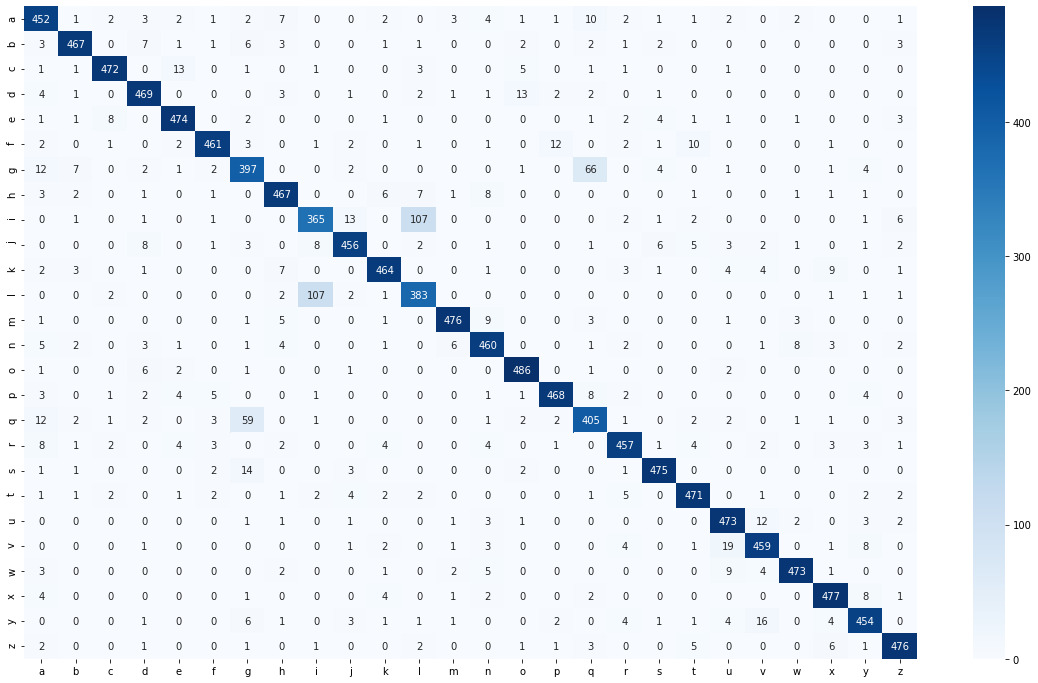

In [ ]:
from sklearn import metrics
import seaborn as sns

PTD = ['p', 't', 'd']
full_data = {i: torch.rand(0).to(device) for i in PTD}

for data, target in test_loader:
        tmp = {'d': data.to(device), 't': target.to(device)}                                        
        output = net(tmp['d']) 
          
        _, tmp['p'] = torch.max(output.data, 1)
       
        full_data = {i: torch.cat((full_data[i], tmp[i])) for i in PTD}

full_data = {i: full_data[i].cpu() for i in PTD}
cm = metrics.confusion_matrix(full_data['t'], full_data['p'])
cm_df = pd.DataFrame(cm, columns=LABELS, index=LABELS)

plt.figure(figsize=(20, 12))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='')
plt.show()


In [ ]:
cm_sum = np.triu(cm).transpose() + np.tril(cm)
top = sorted([[cm_sum[i, j], i, j] for i in range(len(cm_sum)) for j in range(i)], reverse=True)
for i in top[:10]:
  print('буквы:', LABELS[i[1]], LABELS[i[2]], 'количество ошибок:', i[0])

буквы: l i количество ошибок: 214
буквы: q g количество ошибок: 125
буквы: v u количество ошибок: 31
буквы: y v количество ошибок: 24
буквы: q a количество ошибок: 22
буквы: j i количество ошибок: 21
буквы: e c количество ошибок: 21
буквы: o d количество ошибок: 19
буквы: s g количество ошибок: 18
буквы: p f количество ошибок: 17


фамилия Кузьмин, точность K

In [ ]:
cm[10][10]/500

0.928

**примеры**

In [ ]:
mask = torch.ne(full_data['p'], full_data['t'])
wrong_pair = {(i, j): [] for i in LABELS for j in LABELS}
for i in np.where(mask.numpy() == True)[0]:
  wrong_pair[(LABELS[int(full_data['p'][i].item())], LABELS[int(full_data['t'][i].item())])].append(full_data['d'][i])

In [ ]:
def rand_pair(p, t):
  plt.title(f'prediction:{p}, real label:{t}')
  try:
    tenz = random.choice(wrong_pair[(p, t)])
  except:
    print('эти буквы не путают')
    return
  plt.imshow(tenz.numpy()[0].transpose()*0.485 + 0.229, cmap='gray')

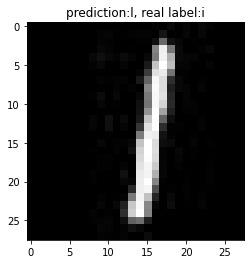

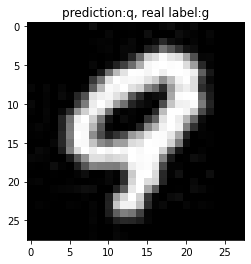

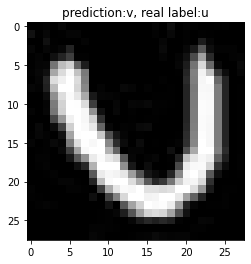

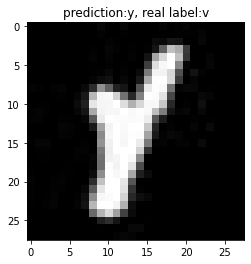

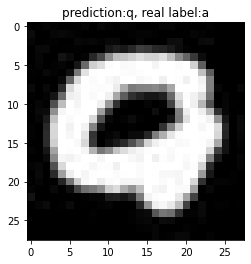

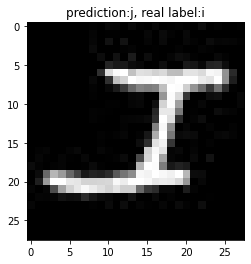

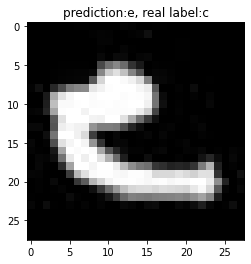

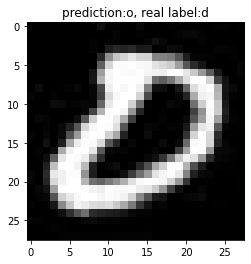

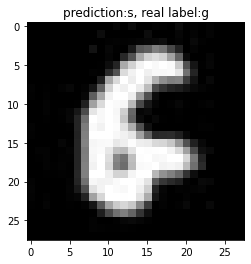

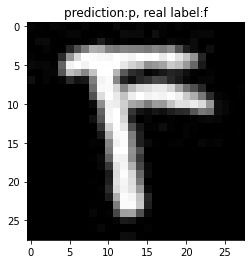

In [ ]:
for i, p in enumerate(top[:10]):
  plt.figure(i)
  rand_pair(LABELS[p[1]], LABELS[p[2]])
plt.show()

### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

**1 свёрточный сллой**

Качество сильно падает при изменнении количество выходных каналов в 3 или более раз, при неадекватно большом размере свёртки и при отсутствии пулинга и 1 FC слое.

В остальном при изменении параметров модели качество практически не меняется.

Модель достаточно быстро начинает переобучаться, l2 нормализация помогает избежать переобучения при значениях 0.0001 до 0.001, при более сильно регуляризации модель перестаёт обучаться. Кроме того, регуляризация по сути не увеличивает качество.

Нормализация батчей и добавление дополнительных FC слоёв на качество опять же практически не влияют.



Лучшая модель:

In [ ]:
class Net_(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn2d1 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*(12)**2, 512)
        self.fc2 = nn.Linear(512, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn2d1(x)
        x = torch.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        #print(x.size())

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [ ]:
net = Net().to(device)

In [ ]:
optimizer= optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 5], gamma=0.2, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
for i in range(7):
  train(net, train_loader, criterion, optimizer, scheduler, device, i)
  test(net, criterion, device, test_loader)

'Train Epoch: 0 [65000/65000 (100%)] Loss: 0.207168'

Train set: Average loss: 0.5525, Accuracy: 53828/65000 83%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.3710, Accuracy: 11390/13000 (88%)



'Train Epoch: 1 [65000/65000 (100%)] Loss: 0.186816'

Train set: Average loss: 0.2855, Accuracy: 58820/65000 90%

Adjusting learning rate of group 0 to 2.0000e-04.
Val set: Average loss: 0.2825, Accuracy: 11806/13000 (91%)



'Train Epoch: 2 [65000/65000 (100%)] Loss: 0.191265'

Train set: Average loss: 0.1684, Accuracy: 61271/65000 94%

Adjusting learning rate of group 0 to 2.0000e-04.
Val set: Average loss: 0.2165, Accuracy: 12068/13000 (93%)



'Train Epoch: 3 [65000/65000 (100%)] Loss: 0.122325'

Train set: Average loss: 0.1489, Accuracy: 61802/65000 95%

Adjusting learning rate of group 0 to 2.0000e-04.
Val set: Average loss: 0.2143, Accuracy: 12119/13000 (93%)



'Train Epoch: 4 [65000/65000 (100%)] Loss: 0.118177'

Train set: Average loss: 0.1390, Accuracy: 61964/65000 95%

Adjusting learning rate of group 0 to 4.0000e-05.
Val set: Average loss: 0.2159, Accuracy: 12093/13000 (93%)



'Train Epoch: 5 [65000/65000 (100%)] Loss: 0.135280'

Train set: Average loss: 0.1104, Accuracy: 62701/65000 96%

Adjusting learning rate of group 0 to 4.0000e-05.
Val set: Average loss: 0.2017, Accuracy: 12120/13000 (93%)



'Train Epoch: 6 [65000/65000 (100%)] Loss: 0.114175'

Train set: Average loss: 0.1056, Accuracy: 62887/65000 97%

Adjusting learning rate of group 0 to 4.0000e-05.
Val set: Average loss: 0.2027, Accuracy: 12120/13000 (93%)



**2 свёрточных слоя**

Batch Norm очень сильно ухудшил качество. Group Norm выполнил функцию регуляризации, но качество осталось прежним.

в остальном ситуация как и с предыдущей моделью.


Лучшая модель:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.bn2d1 = nn.BatchNorm2d(64)
        self.gn1 = nn.GroupNorm(8, 64)
        self.fc1 = nn.Linear(64*(11)**2, 512)
        self.fc2 = nn.Linear(512, 26)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.gn1(x)
        x = torch.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        #x = self.gn1(x)
        x = torch.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        #print(x.size())

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [ ]:
net = Net().to(device)

In [ ]:
optimizer= optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3], gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
for i in range(5):
  train(net, train_loader, criterion, optimizer, scheduler, device, i)
  test(net, criterion, device, test_loader)

'Train Epoch: 0 [65000/65000 (100%)] Loss: 0.220560'

Train set: Average loss: 0.4715, Accuracy: 55387/65000 85%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.2623, Accuracy: 11880/13000 (91%)



'Train Epoch: 1 [65000/65000 (100%)] Loss: 0.257992'

Train set: Average loss: 0.2329, Accuracy: 59899/65000 92%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.2634, Accuracy: 11881/13000 (91%)



'Train Epoch: 2 [65000/65000 (100%)] Loss: 0.083835'

Train set: Average loss: 0.1280, Accuracy: 62054/65000 95%

Adjusting learning rate of group 0 to 1.0000e-05.
Val set: Average loss: 0.1922, Accuracy: 12176/13000 (94%)



'Train Epoch: 3 [65000/65000 (100%)] Loss: 0.071442'

Train set: Average loss: 0.1005, Accuracy: 62705/65000 96%

Adjusting learning rate of group 0 to 1.0000e-05.
Val set: Average loss: 0.1894, Accuracy: 12203/13000 (94%)



**3 свёрточных слоя**

Лучшая модель:

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=7, stride=1, padding=0)
        
        self.bn2d1 = nn.BatchNorm2d(64)
        self.gn1 = nn.GroupNorm(8, 64)
        
        self.fc1 = nn.Linear(48*(8)**2, 512)
        self.fc2 = nn.Linear(512, 26)

    def forward(self, x):
        x = self.conv1(x)
        #x = self.gn1(x)
        x = torch.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        #x = self.gn1(x)
        x = torch.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        #x = self.gn1(x)
        x = torch.relu(x)
        
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        #print(x.size())

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [87]:
net_main = Net().to(device)

In [88]:
optimizer= optim.Adam(net_main.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3], gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [89]:
for i in range(4):
  train(net_main, train_loader, criterion, optimizer, scheduler, device, i)
  test(net_main, criterion, device, test_loader, True)

'Train Epoch: 0 [43360/65000 (100%)] Loss: 0.158776'

Train set: Average loss: 0.4273, Accuracy: 56234/65000 87%

Adjusting learning rate of group 0 to 1.0000e-03.
Val set: Average loss: 0.2317, Accuracy: 11985/13000 (92%)



'Train Epoch: 1 [43360/65000 (100%)] Loss: 0.150922'

Train set: Average loss: 0.1978, Accuracy: 60595/65000 93%

Adjusting learning rate of group 0 to 1.0000e-04.
Val set: Average loss: 0.2028, Accuracy: 12090/13000 (93%)



'Train Epoch: 2 [43360/65000 (100%)] Loss: 0.205635'

Train set: Average loss: 0.1074, Accuracy: 62393/65000 96%

Adjusting learning rate of group 0 to 1.0000e-05.
Val set: Average loss: 0.1663, Accuracy: 12300/13000 (95%)



'Train Epoch: 3 [43360/65000 (100%)] Loss: 0.126163'

Train set: Average loss: 0.0866, Accuracy: 62913/65000 97%

Adjusting learning rate of group 0 to 1.0000e-05.
Val set: Average loss: 0.1647, Accuracy: 12317/13000 (95%)



**сравнение batc и group norm**

In [24]:
class Net_n(nn.Module):
    def __init__(self, norm='b'):
        super(Net_n, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=7, stride=1, padding=0)
        
        self.bn2d1 = nn.BatchNorm2d(48)
        self.bn2d2 = nn.BatchNorm2d(64)
        self.gn1 = nn.GroupNorm(8, 48)
        self.gn2 = nn.GroupNorm(8, 64)
        
        self.fc1 = nn.Linear(48*(8)**2, 512)
        self.fc2 = nn.Linear(512, 26)

        self.norm = norm

    def forward(self, x):
        x = self.conv1(x)
        if self.norm == 'b':
          x = self.bn2d1(x)
        x = self.gn1(x)
        x = torch.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        if self.norm == 'b':
          x = self.bn2d2(x)
        x = self.gn2(x)
        x = torch.relu(x)
        #x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        if self.norm == 'b':
          x = self.bn2d1(x)
        x = self.gn1(x)
        x = torch.relu(x)
        
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        #print(x.size())

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [25]:
acc = {'b': [], 'g': []}
for i in range(20, 121, 20):
  print('batc:', i)
  train_loader = DataLoader(datasets.ImageFolder(root = 'train', transform=preprocess), batch_size=i, shuffle=True, **kwargs) 
  test_loader = DataLoader(datasets.ImageFolder(root = 'test', transform=preprocess), batch_size=i, shuffle=True, **kwargs) 

  for t in ['b', 'g']:
    net = Net_n(norm=t).to(device)
    optimizer= optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3], gamma=0.1, verbose=False)
    for i in range(4):
      train(net, train_loader, criterion, optimizer, scheduler, device, i, verbose=False)
    res = test(net, criterion, device, test_loader, verbose=False)[1]
    acc[t].append(res)


batc: 20
batc: 40
batc: 60
batc: 80
batc: 100
batc: 120


batch norm справляется намного намного хуже, а group norm по сути не влияет на качество.

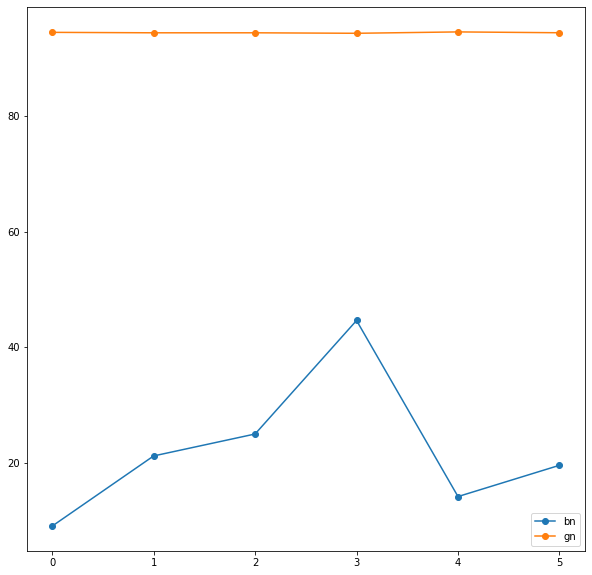

In [28]:
plt.figure(figsize=(10, 10))
plt.plot(acc['b'], marker='o', label='bn')
plt.plot(acc['g'], marker='o', label='gn')
plt.legend()
plt.show()

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

95% представленна в предыдущем задании

## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

In [90]:
class Negative:

  def __call__(self, x):
    x = 255-x
    return x

preprocess=transforms.Compose([
    torchvision.transforms.Resize((28, 28), interpolation=2),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    Negative(),
    transforms.Normalize(mean=[0.485],
                         std=[0.229] )
    ])

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

test_dataset_l = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/letters', transform=preprocess)
test_loader_l  = torch.utils.data.DataLoader(test_dataset_l, batch_size=1, shuffle=False, **kwargs) 

No handles with labels found to put in legend.


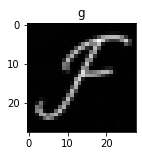

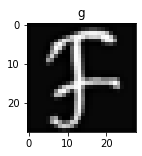

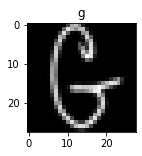

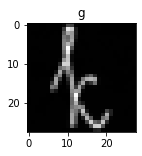

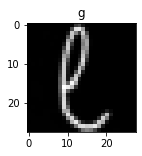

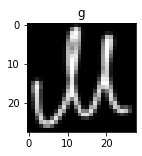

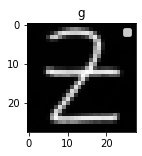

In [100]:

i=0
for data, _ in test_loader_l:
  #print(i, data)
  data = data.to(device)
  out = net_main(data)
  
  pred = out.argmax(dim=1, keepdim=True)
  plt.figure(i, figsize=(2,2))
  plt.title(LABELS[pred.item()])
  plt.imshow(data.cpu().view(-1, 28), cmap='gray')
  i+=1


plt.legend()
plt.show()

Модель всегда предсказывает букву g :(

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.